## Classification of Speech Frames

### FROM FBANK, FBANK-PCA or CEPSTRAL FEATURES

### 1. Setting up your Python Environment
 
1. Import all required Python Modules  
  - Python's Baseline Machine Learning Stack       
  - Specific utilities that are needed for this exercise     
2. Set some default plotting and printing options

In [2]:
# Import Python's baseline machine learning stack 
#   and some io modules
%matplotlib inline
import sys,os,io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import scipy.io as sio
import urllib.request

# import from the scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture
# import the DCT transform from scipy
from scipy.fftpack import dct

# import our GaussianMixture Classifier  (install if needed from github)
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False
from pyspch.GaussianMixtureClf import GaussianMixtureClf

In [3]:
# just setting some plotting & formatting options, you can modify at will
# choose the colors you like :)
palette = sns.color_palette("bright")
# palette=['red','green','blue','orange','brown','black','dodgerblue','mediumturquoise','cyan','violet','gold','salmon'] 
sns.set_palette(palette)
# sns.palplot(palette)

# set precision in pandas for float outputs
#pd.reset_option('display.float_format')
pd.set_option('precision',2)

### 2. The Database 
The experiments in this notebook use a subset of the TIMIT database.
There is MEL SCALED FILTERBANK data from 3 vowels (i,a,uw) , 800 samples for training and 200 samples for testing.
The data is 24-dimensional containing the log energy in each of the 24 filterbank channels (each 1 mel wide).

In the cell below the data is loaded into
- data matrices   FBANK_train(2400,3), FBANK_test(600,3)
- labels          y_train(2400,), y_test(600,)

In [4]:
# loads all data in a matlab file at given url to the contents structure
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)
#
# we import 800 train samples and 200 test samples for 3 vowels
tinytimit = 'http://homes.esat.kuleuven.be/~spchlab/datasets/tinytimit/'
url_mf = tinytimit + 'male-female.mat' 
data_mf = load_matlab_from_url(url_mf)
url_vow3= tinytimit + 'a-i-uw-800.mat' 
data_vow3 = load_matlab_from_url(url_vow3)
#
# we subtract a very rough normalization factor (as original data was not scaled before DFT)
norm_fac = 40.0
FB_train=data_vow3['ALLtrain'].T - norm_fac
FB_test=data_vow3['ALLtest'].T - norm_fac
y_train =np.full((2400,),'a',dtype='<U2')
y_train[800:1600] =np.full((800,),'i',dtype='<U2')
y_train[1600:2400] =np.full((800,),'uw',dtype='<U2')
y_test =np.full((600,),'a',dtype='<U2')
y_test[200:400] =np.full((200,),'i',dtype='<U2')
y_test[400:600] =np.full((200,),'uw',dtype='<U2')
classes = np.unique(y_train)

### 3a. Data Exploration ... of filterbank data

How to explore data in 24-dimensional space ?

There is no trivial answer to this question.  
First we try to visualize scatter plots of the first couple of filterbank energies

Scatter plots may give us an insight as to which features are most relevant.
We can make a simple scatter plot with 2 preselected features, or can have a conglomerate of scatter plots for a getter overview

##### Tasks & Questions (1)
1. What do the scatter plots tell you.  Are there features that must be retained or others that can surely be dropped ?

<Figure size 720x720 with 0 Axes>

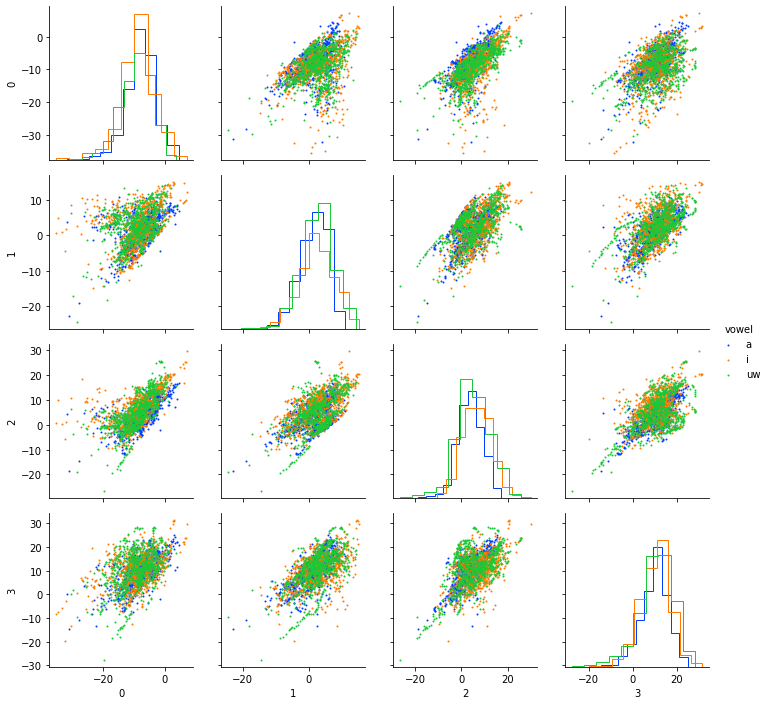

In [5]:
# we use the sns.PairGrid method to construct a multitude of scatter plots over the first 
# filterbank coefficients
dfX = pd.DataFrame(FB_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
f=plt.figure(figsize=(10,10))
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

### 3b. Data Exploration .. of projected data

While there might be lots of information in this 24-dimensional data. It is not simple to observe it.
Definitely it is not obvious in the first couple of filterbank coefficients.
We definitely run into the limitations of 3-D visual representation.

A common approach for a quick analysis is to project the data on its most important axes by Principal Component Analysis (PCA).   PCA just looks at the overall distribution of all data without taking the labels into account.  Hence it is an unsupervised method. 
We will not give any mathematical background here, but just think of looking in the best possible low-dimensional subspace of the full 24-dimensional space.

In the gridplot below, we make scatterplots of different combinations of PCA coefficients; the bottom left hand side of the plots show the raw datapoints; the top right hand side shows density approximations.

##### Tasks & Questions (2)
1. What do these new scatter plots tell you?  Can you make a general statement about the distributions of PCA features ?
2. In what units are the PCA-axis ?
3. Any idea if the original filterbank features will perform better or worse than the PCA features ?
4. If you may only use 2 PCA coefficients, which ones will you choose ?

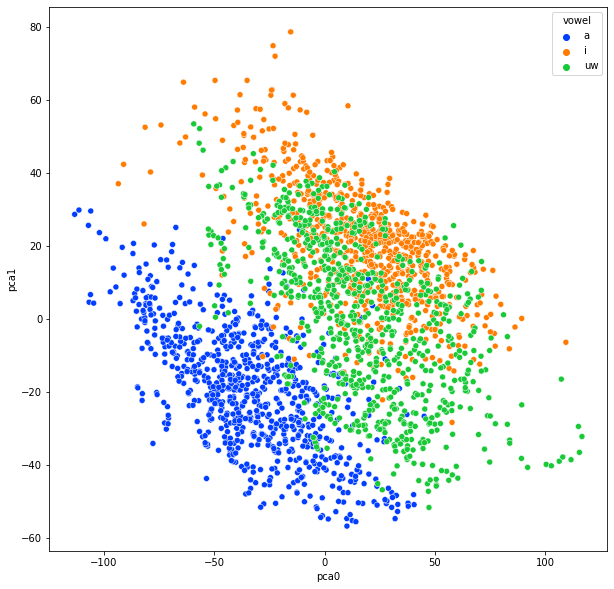

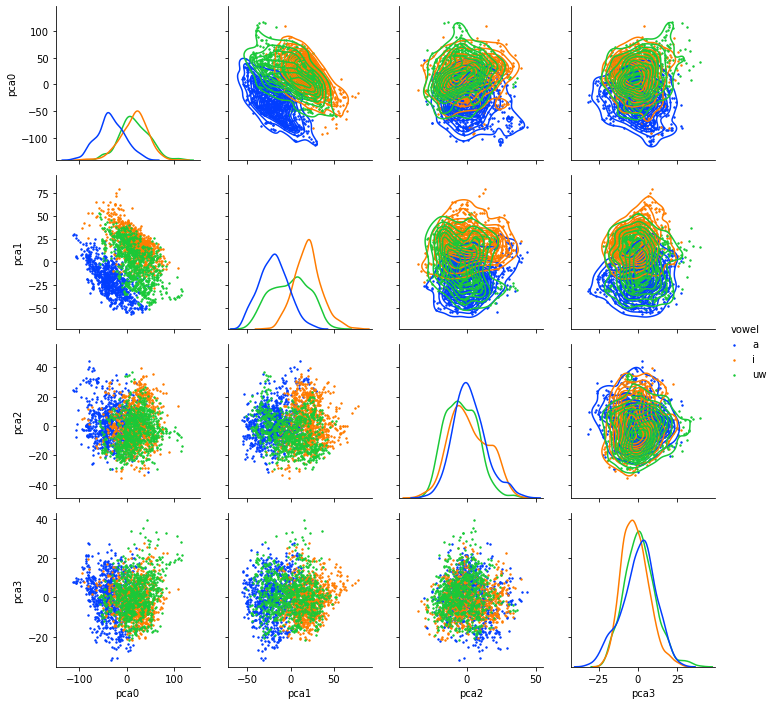

In [6]:
from sklearn.decomposition import PCA
plt.close(f)
pca = PCA()
T = pca.fit(FB_train)
PCA_train = T.transform(FB_train)
PCA_test = T.transform(FB_test)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
#
df.columns=["vowel","pca0","pca1","pca2","pca3"]
f=plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x="pca0",y="pca1",hue='vowel')
g = sns.PairGrid(df,hue="vowel")
# on the diagonal we can plot a histogram or a smooth kernel density plot
#g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_diag(sns.kdeplot)
g.map_offdiag(plt.scatter,s=2)
g.map_upper(sns.kdeplot)
g.add_legend()

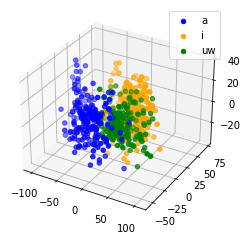

In [7]:
# we can also try to look in 3D ...
# .. but that's the limit of our visual capacity and the data is still 24-D !
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[0:200,"pca0"], df.loc[0:200,"pca1"], df.loc[0:200,"pca2"], c='blue', s=20)
ax.scatter(df.loc[800:1000,"pca0"], df.loc[800:1000,"pca1"], df.loc[800:1000,"pca2"], c='orange', s=20)
ax.scatter(df.loc[1600:1800,"pca0"], df.loc[1600:1800,"pca1"], df.loc[1600:1800,"pca2"], c='green', s=20)
plt.legend(['a','i','uw'])
plt.show()


### 3c. Data Exploration .. MFCC features

PCA is a very common technique in machine learning in general to achieve dimensionality reduction, especially when we are dealing with unsupersived settings. It is not commonly used in tasks where we have plenty of labeled data, as is the case for speech recognition.   In such circumstances two alternatives give consistently better performance: LDA or CEPSTRAL transformations.  LDA is generic, the cepstrum is known to work well with speech filterbank data.
Both are linear transformations, similar to PCA, but conceptually quite different
- PCA looks at the global data and gives a look along the most informative axes.  After transformation the global data is centered at the origin and almost normally distributed.
- LDA is also a global transformation, however it takes class information into account in its optimization criterion.  LDA makes gross assumptions, namely that all classes are normally distributed with identical covariances.  Despite these unrealistic assumptions, LDA tends to  outperform PCA by a rather large margin in most machine learning tasks, including speech recognition. Another disadvantage of LDA is that it is learned from the labeled data, making it dependent on language, task and database.
- The Cepstrum: is derived from the spectrum or filterbank energies via a DCT transform.  Its performance is close to LDA and has as great advantage that it is generic.  Also - almost magically - cepstral features are highly decorrelated and almost normally distributed making them very well suited for machine learning applications.   When the DCT is applied on a mel scaled spectrum (or mel filterbank energies) we call the output MEL FREQUENCY CEPSTRAL COEFFICIENTS (or MFCCs).   Finally they are very compact, making them "cheap" to work with. For all these reasons MFCCs have been a reference feature representation for speech recognition for decades.  While maybe not the best anymore, they are still very relevant for development, prototyping or embedded applications.


MFCC's: Mel Frequency Cepstra
=============================
MFCC's are obtained by taking a DCT (discrete cosine transform) of log filterbank energies.
The FBANK features we start from in this exercise are these log filterbank energies.
 
In the first set of figures we compare side by side prototypical spectra with prototypical cepstra of our 3 vowels in the database.  You can turn on/off optional mean normalization such that the global distributions become zero-centered.  While the spectra are more intuitive, we will later see the power of the cepstral coefficients.  Note already 
that the FBANK's here are 24-Dimensional, while we limited the dimensionality of the cepstra to 13. 

The second set of figures shows scattered plots as with PCA features.

##### Tasks & Questions (3)
1. What do these new scatter plots tell you?
2. In what units are the MFCC-axis ?
3. Any preferred features by now ?
4. Anything remarkable about the global variance of cepstral coefficients ? How would the plot of the prototyical cepstra look if we had applied mean **and** variance normalization ?


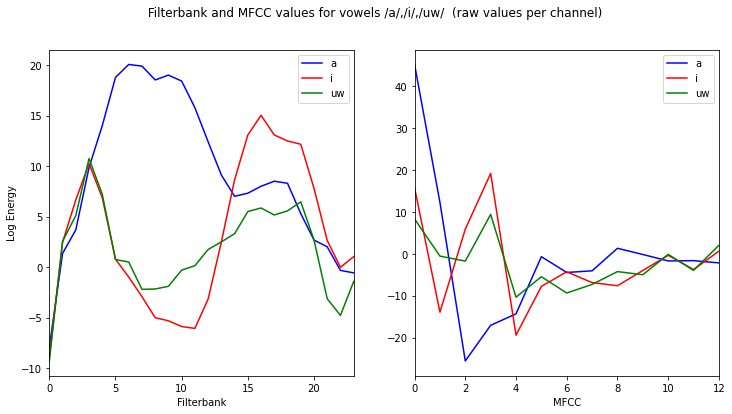

In [8]:
#  set MEAN_NORM to True if you want to display mean normalized values
#  leave MEAN_NORM at False if you want to display raw values
MEAN_NORM = False

MFCC_train = dct(FB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(FB_test, type=2, axis=1, norm='ortho')


if MEAN_NORM:
  FBmean = np.mean(FB_train,0)
  MFCCmean = np.mean(MFCC_train,0)
else:
  FBmean = 0
  MFCCmean = 0

FB_typ_a = np.mean(FB_train[0:800,:],0) - FBmean
FB_typ_i = np.mean(FB_train[800:1600,:],0) - FBmean
FB_typ_uw = np.mean(FB_train[1600:2400,:],0) - FBmean
MFCC_typ_a = np.mean(MFCC_train[0:800,:],0) - MFCCmean
MFCC_typ_i = np.mean(MFCC_train[800:1600,:],0) -MFCCmean
MFCC_typ_uw = np.mean(MFCC_train[1600:2400,:],0) -MFCCmean


fig= plt.figure(figsize=(12,6))

ax = fig.add_subplot(121)
ax.plot(FB_typ_a,color='blue')
ax.plot(FB_typ_i,color='red')
ax.plot(FB_typ_uw,color='green')
ax.legend(['a','i','uw'])
ax.set_xlabel('Filterbank')
ax.set_xlim(0,23)
ax.set_ylabel('Log Energy')
#plt.show()

ax = fig.add_subplot(122)
ax.plot(MFCC_typ_a,color='blue')
ax.plot(MFCC_typ_i,color='red')
ax.plot(MFCC_typ_uw,color='green')
ax.legend(['a','i','uw'])
ax.set_xlabel('MFCC')
ax.set_xlim(0,12)
ax.set_ylabel('')
if MEAN_NORM:
  plt.suptitle(' Filterbank and MFCC values for vowels /a/,/i/,/uw/  (mean normalization per channel)')
else:
  plt.suptitle(' Filterbank and MFCC values for vowels /a/,/i/,/uw/  (raw values per channel)')
plt.show()

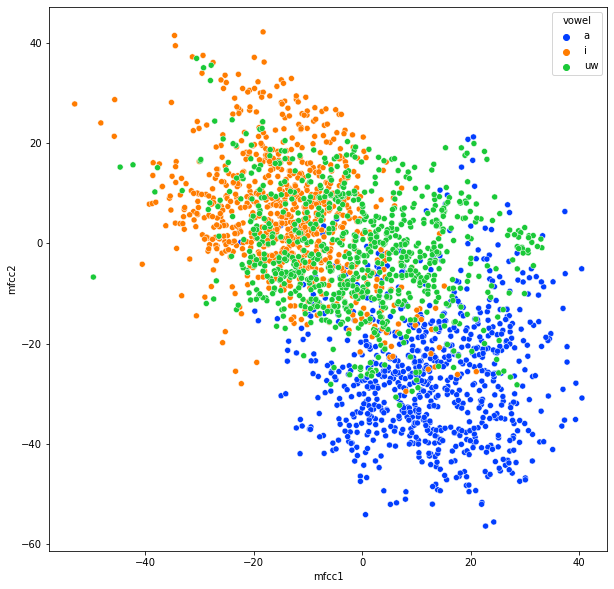

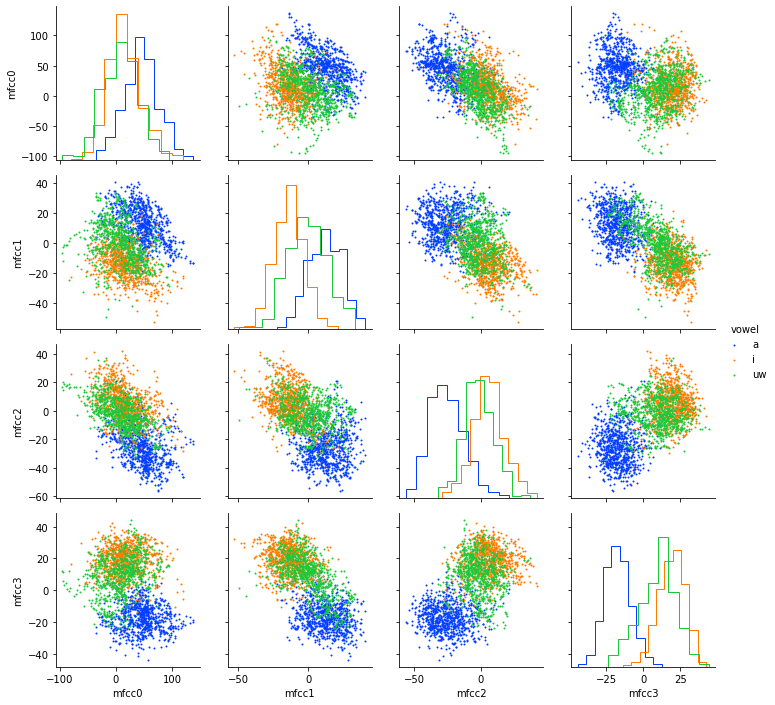

In [9]:
dfX = pd.DataFrame(MFCC_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
df.columns=["vowel","mfcc0","mfcc1","mfcc2","mfcc3"]
#
f=plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x="mfcc1",y="mfcc2",hue='vowel')
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

### 4. Classification using a Bayesian classifier and Gaussian models

We will now explore the merit of the different representations in function of speech recognition performance.
We use the class *GaussianMixtureClf*  as provided in *spchutils* .
It is implemented as an extension to *sklearn*, using the same APIs and making use of the sklearn GaussianMixture density estimator.

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian Mixture Model
- n_dim: the dimension of the feature vector (should be less than 24 in all cases)
- feature_type: "MFCC", "FBANK" or "PCA"
- max_iter:  maximum number of iterations in EM algorithm 

##### Note
You may get convergence warnings with certain settings.  It is probably an indication that you are trying to fit too many parameters with the available data.
In this case it probably is an indication that n_components is too big for the available data

##### Task & Questions (4)
1. How important in n_dim ?
2. How important is n_components ?
3. How important is it in this case to do PCA first ?
4. How similar is test performance on an independent test set when compared with predicted performance from train set ?  Do you see differences between the 3 different feature types?  Do you see differences with increasing feature dimension and number of components ?

In [10]:
# evaluation routine that returns accuracy on train and test set and confusion matrix

def plot_confusion_matrix(cm,labels=[],cmap=[]):
# note (08/11/2019): seaborn heatmaps in sns 0.9.0 have top and bottom cut off when using matplotlib 3.1.1
# you can either downgrade matplotlib or install matplotlib 3.1.2 which should be available shortly

    if len(labels) == 0:
        df_cm = pd.DataFrame(cm)
    else:
        df_cm = pd.DataFrame(cm, labels, labels)
        
    f,ax = plt.subplots(figsize=(3,3))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"fontsize": 14,"color":'k'},
                square=True,linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    # font size
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def train_test_model(X_train,X_test,y_train,y_test,classes,
                     n_components=1,max_iter=20,tol=1.e-3,print_result=True,print_cmat=False):
    clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=20,tol=1.e-3)
    clf_GM.fit(X_train,y_train)
    y_pred = clf_GM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    y_pred = clf_GM.predict(X_test)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    cmat = skmetrics.confusion_matrix(y_test,y_pred)
    if(print_result):
        lls, bics = llscore(clf_GM,X_train,y_train)
        print('Training Set:  Accuracy = %.2f%%     LL = %.2f    BIC = %.2f ' % (acc_train,lls,bics) )
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    if(print_cmat):
        plot_confusion_matrix(cmat,labels=classes)
    return (acc_test,acc_train)

def llscore(GMM,X,y):
    ''' Average log likelihood per sample over the full data set (X,y) 
    and BIC per sample '''
    ll = 0.
    for k in range(0,GMM.n_classes) :
        ll += GMM.gmm[k].score(X[y== GMM.classes[k],: ])
    lls = ll.mean()
    nparam = ((2*n_dim+1)*n_components -1 ) * GMM.n_classes
    bics = -2*lls + (np.log(X.shape[0])* nparam) / float(X.shape[0])
    return(lls,bics)


*** feature_type=MFCC, dim=13, n_components=1 ***
Training Set:  Accuracy = 84.42%     LL = -136.21    BIC = 272.66 
Test Set:      Accuracy = 83.33%


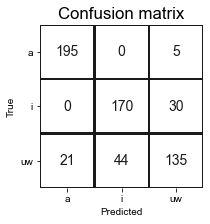

In [11]:
# to analyze different configurations
# change the parameters feature_type, n_dim or n_components in the following lines
# if you want to exclue global energy (~ mfcc[0]), then adjust expressions for feature selection to  1:n_dim
#
feature_type = "MFCC"  # any of MFCC, FBANK or PCA
n_dim = 13            #  feature dimensions to test
n_components = 1      #  n_components to test
#
    
X_train = eval("%s_train[:,0:n_dim]"%feature_type)
X_test = eval("%s_test[:,0:n_dim]"%feature_type)
print("*** feature_type=%s, dim=%d, n_components=%d ***" % (feature_type,n_dim,n_components))
_,_ = train_test_model(X_train,X_test,y_train,y_test,classes,n_components=n_components,print_result=True,print_cmat=True)


In [12]:
# in this cell you can do a full scale analysis with multiple settings
# it basically lets you iterate over the same parameters as above
# and summarizes your results in a table


# --------------
feature_type_test = ["FB","PCA","MFCC"]   # any of MFCC, FB or PCA
n_dim_test = [ 4, 8, 13, 24 ]            # list of feature dimensions to test
n_components_test = [1]                    # list of n_components to test
max_iter = 10                                # maximum number of iterations in the EM algorithm

# --------------
result_list=[]
for feature_type in feature_type_test:
    for n_components in n_components_test:
        for n_dim in n_dim_test:  
            X_train = eval("%s_train[:,0:n_dim]"%feature_type)
            X_test = eval("%s_test[:,0:n_dim]"%feature_type)
          
            acc_test, acc_train = train_test_model(X_train,X_test,y_train,y_test,classes,
                                n_components=n_components,print_result=False)
            result_list.append({"features":feature_type,"dim":n_dim,
                                "n_c":n_components,"acc_train":acc_train,"acc_test":acc_test})
    
df_list=pd.DataFrame(result_list,columns=["features","dim","n_c","acc_train","acc_test"])
df = df_list.set_index(["features","n_c","dim"])
#pd.set_option('precision',2)
#print(df.to_string())
HTML(df.to_html())

### 5. Classification using a Neural Net

Finally we compare our classification results using Gaussian Mixtures (GMM) with a Neural Net (NN) classifier.  For this application we may use the simplest of all neural nets: a multilayer perceptron (MLP).

We have set acceptable training parameters for you.  The things we are interested in is the impact of different features (type and dimension) and the size of the network.

##### Tasks & Questions (5)
1. When you compare results from the GMM vs NN classifiers, what is the most striking difference that you observe ?
2. How do you rank the different feature representations (FBANK vs. MFCC) ?  Is there a difference between the GMM and NN case ?
3. How do you rank the different feature dimensions (let's say 13 sv. 24) ?  Any notable difference between the GMM and NN case ?
4. After all the performed experiments, pls. judge the following statements
  - MFCCs outperform FBANK features
  - GMMs are better classifiers than NNs


In [13]:
from sklearn.neural_network import MLPClassifier

# ------ different parameters to be explored --------
feature_type_test = ["FBANK", "MFCC"]  # any combination of MFCC, FBANK or PCA
n_dim_test = [ 13, 24 ]   # list of feature dimensions to test
hidden_layers_test = [(256) , (512) , (1024), (512,512) , (256,256,256) ]  # network configurations
learning_rate_test = [ 0.005 ]   # initial learning rates for the network training

# ----- extra parameters that can be changed, but might be fine for most tests
max_iter = 500  # maximum number of iterations in the backpropagation algorithm
momentum = 0.9  # only for SGD
early_stopping = True
validation_fraction = 0.1

# --------------

results = pd.DataFrame(columns=["features","hidden layers", "lr","train acc","test acc"])
#results = []
for feature_type in feature_type_test:
  for n_dim in n_dim_test:
    features = feature_type+"("+str(n_dim)+")"
    for hidden_layer_sizes in hidden_layers_test:
        for learning_rate_init in learning_rate_test:
            if feature_type == "PCA":
                X_train = FB_pca_train[:,0:n_dim]   
                X_test  = FB_pca_test[:,0:n_dim]    
            elif feature_type == "FBANK":
                X_train = FB_train[:,0:n_dim]   
                X_test  = FB_test[:,0:n_dim]
            elif feature_type == "MFCC":
                X_train = MFCC_train[:,0:n_dim]   
                X_test  = MFCC_test[:,0:n_dim]    

            clf_MLP = MLPClassifier(solver='adam', 
                                    learning_rate_init=learning_rate_init,
                                    hidden_layer_sizes=hidden_layer_sizes,
                                    max_iter=max_iter, alpha=1e-5, random_state=1,
                                    early_stopping=early_stopping,
                                    validation_fraction=validation_fraction)
            clf_MLP.fit(X_train,y_train)

            #print("*** feature_type(dim=%d), hidden layers=%s, lr=%.5f ***" %       (n_dim,hidden_layer_sizes,learning_rate_init))
            y_pred = clf_MLP.predict(X_train)
            train_acc = 100.0*skmetrics.accuracy_score(y_train, y_pred)
            # print('Train Set Accuracy: %.2f%%' % (100.0*train_acc))
            y_pred = clf_MLP.predict(X_test)
            test_acc = 100.0*skmetrics.accuracy_score(y_test, y_pred)
            cmat = skmetrics.confusion_matrix(y_test,y_pred)

            # 3. print and save results            
            print('%s(dim=%d)  layers=%s   lr=%.5f     Train Accuracy:%.2f%%    Test Accuracy: %.2f%%' % (feature_type,n_dim,hidden_layer_sizes,learning_rate_init,train_acc,test_acc))
            results = results.append({'features':features,"hidden layers":str(hidden_layer_sizes),'lr': learning_rate_init,'train acc': train_acc,'test acc': test_acc},ignore_index=True)
    
print_df = results.set_index(["features","hidden layers","lr"])
HTML(print_df.to_html())



FBANK(dim=13)  layers=256   lr=0.00500     Train Accuracy:92.58%    Test Accuracy: 75.50%
FBANK(dim=13)  layers=512   lr=0.00500     Train Accuracy:92.58%    Test Accuracy: 77.00%
FBANK(dim=13)  layers=1024   lr=0.00500     Train Accuracy:84.88%    Test Accuracy: 76.67%
FBANK(dim=13)  layers=(512, 512)   lr=0.00500     Train Accuracy:97.54%    Test Accuracy: 77.00%
FBANK(dim=13)  layers=(256, 256, 256)   lr=0.00500     Train Accuracy:95.25%    Test Accuracy: 76.50%
FBANK(dim=24)  layers=256   lr=0.00500     Train Accuracy:96.67%    Test Accuracy: 78.83%
FBANK(dim=24)  layers=512   lr=0.00500     Train Accuracy:99.62%    Test Accuracy: 82.83%
FBANK(dim=24)  layers=1024   lr=0.00500     Train Accuracy:97.33%    Test Accuracy: 80.00%
FBANK(dim=24)  layers=(512, 512)   lr=0.00500     Train Accuracy:96.96%    Test Accuracy: 80.67%
FBANK(dim=24)  layers=(256, 256, 256)   lr=0.00500     Train Accuracy:99.42%    Test Accuracy: 78.17%
MFCC(dim=13)  layers=256   lr=0.00500     Train Accuracy:98.